### Tiled Shot Maps

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects

# only a vertical pitch
from mplsoccer import VerticalPitch

In [3]:
# read data
df = pd.read_csv("../data/efl_championship_shots_07022022.csv", index_col = 0)
df.head()

,matchId,playerName,playerId,min,x,y,shotType,blocked,onTarget,ownGoal,xG,xGOT,eventType,teamId,teamColor,date,teamName
0,3414545,Daryl Horgan,253356,2,101.681034,37.431250,LeftFoot,False,False,False,0.7994,NaN,Miss,8676,#083868,2020-09-12 13:30:00,Wycombe Wanderers
1,3414545,Joe Jacobson,28892,10,58.193332,48.554906,LeftFoot,False,False,False,0.0290,NaN,Miss,8676,#083868,2020-09-12 13:30:00,Wycombe Wanderers
2,3414545,Kieran Sadlier,614458,12,73.024756,29.967858,RightFoot,False,True,False,0.0484,0.3966,AttemptSaved,8119,#DA291C,2020-09-12 13:30:00,Rotherham United
3,3414545,Michael Ihiekwe,280865,12,94.385966,29.715713,Header,False,False,False,0.0414,NaN,Miss,8119,#DA291C,2020-09-12 13:30:00,Rotherham United
4,3414545,Chiedozie Ogbene,674009,28,91.900002,23.929172,LeftFoot,True,True,False,0.0499,NaN,AttemptSaved,8119,#DA291C,2020-09-12 13:30:00,Rotherham United


Explore the locations from where each side generated its most dangerous on-target shots (xGOT).

To start, draw a basic pitch using the VerticalPitch class imported from the mplsoccer package.

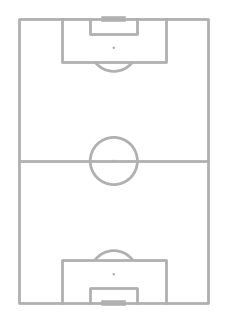

In [4]:
fig = plt.figure(figsize=(4,4), dpi=100)
ax = plt.subplot(111)

pitch = VerticalPitch()

pitch.draw(ax=ax)

Some available pitch types in the mplsoccer package.

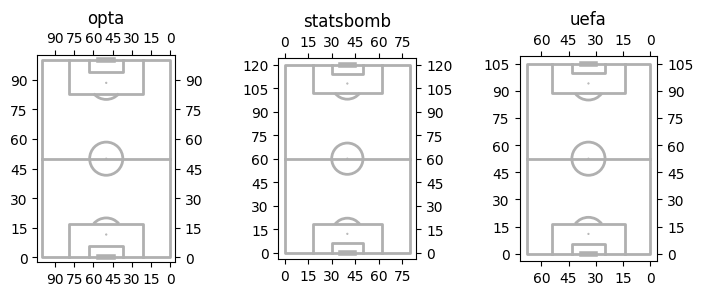

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,5), dpi=100)

providers = ["opta", "statsbomb", "uefa"]
for index, ax in enumerate(axes.flat):
    pitch = VerticalPitch(
        pitch_type = providers[index], 
        axis = True, 
        label = True, 
        tick = True
    )
    pitch.draw(ax=ax)

    # to view more ticks in the chart
    ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(15))

    ax.set_title(providers[index])

plt.subplots_adjust(wspace=0.75)

In this case, we're working with a UEFA pitch type defined in meters, 105 meters wide by 68 meters high.

Note that the x and y axes are inverted since we have a vertical pitch.

Plot a hypothetical shot in our UEFA pitch and draw a red line on the edge of the 18-yard box (~16.5 meters).

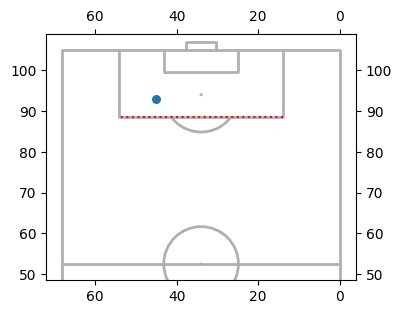

In [6]:
fig = plt.figure(figsize=(4,4), dpi=100)
ax = plt.subplot(111)

# notice the extra parameters passed to the object
pitch = VerticalPitch(
    pitch_type = "uefa",
    half = True,
    axis = True, 
    label = True, 
    tick = True,
    goal_type='box'
)

pitch.draw(ax=ax)
# hypothetical shot
ax.scatter([45],[93], s=30)
# the coordinates of the 18-yard box
x_end = 68 - 13.84
x_start = 13.84
y_position = 105 - 16.5
ax.plot([x_start, x_end], [y_position, y_position], color = "red", ls = ":")

In [7]:
def soc_pitch_divisions(ax, grids=False):
    '''
    This function returns a vertical football pitch
    divided in specific locations.

    Args:
        ax (obj): a matplotlib axes.
        grids (bool): should we draw the grid lines?
    '''

    # notice the extra parameters passed to the object
    pitch = VerticalPitch(
        pitch_type = "uefa",
        half = True,
        goal_type='box',
        linewidth = 1.25,
        line_color='black'
    )

    pitch.draw(ax=ax)

    # where to draw the lines
    if grids:
        y_lines = [105 - 5.5*x for x in range(1,10)]
        x_lines = [68 - 6.8*x for x in range(1,10)]

        for i in x_lines:
            ax.plot(
                [i, i], [45, 105], 
                color = "lightgray", 
                ls = "--",
                lw = 0.75,
                zorder = -1
            )
        for j in y_lines:
            ax.plot(
                [68, 0], [j, j],
                color = "lightgray", 
                ls = "--",
                lw = 0.75,
                zorder = -1
            )

    return ax

<AxesSubplot: >

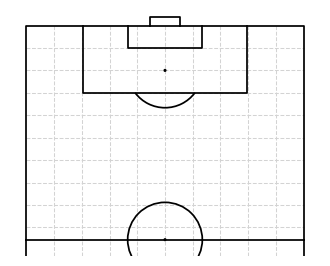

In [8]:
fig = plt.figure(figsize=(4,4), dpi=100)
ax = plt.subplot(111)

soc_pitch_divisions(ax, grids = True)

Now that we have defined the areas through which we'll be dividing the pitch, we can now get back to our DataFrame and aggregate the xGOT created by each side in each location.

First, notice that since we'll be using a vertical pitch, we'll need to invert the coordinates in our df. Plus, we can also define the points that divide each of our bins for both the x and y axes. 

In [9]:
# keep only most recent season data
df = df[df["date"] >= "2021-08-06"].reset_index(drop = True)

# invert our coordinates
df.rename(columns = {"x":"y", "y":"x"}, inplace = True)

# define the cuts for our data (same as our pitch divisions)
# the only difference is that we need to add the edges

y_bins = [105] + [105 - 5.5*x for x in range(1,10)] + [45]
x_bins = [68] + [68 - 6.8*x for x in range(1,10)] + [0]

x_bins.sort()
y_bins.sort()

Next, we use the pd.cut() method to segment the shots into bins, and finally, we group our df and sum the xGOT created by each side.

In [10]:
df["bins_x"] = pd.cut(df["x"], bins=x_bins)
df["bins_y"] = pd.cut(df["y"], bins=y_bins)

# group and sum xGOT by side and location
df_teams = (
    df.groupby(
        ["bins_x", "bins_y", "teamName", "teamId", "teamColor"], 
        observed = True
    )["xGOT"].sum()
    .reset_index()
)

# and we sort it based on the bins_y and bins_x columns
df_teams = (
    df_teams.
    sort_values(by=["bins_y", "bins_x"]).
    reset_index(drop=True)
)

In [11]:
df_teams.head()

,bins_x,bins_y,teamName,teamId,teamColor,xGOT
0,"(27.2, 34.0]","(45.0, 55.5]",AFC Bournemouth,8678,#901818,0.0000
1,"(27.2, 34.0]","(45.0, 55.5]",Fulham,9879,#000000,0.0161
2,"(27.2, 34.0]","(45.0, 55.5]",Millwall,10004,#003078,0.0000
3,"(27.2, 34.0]","(45.0, 55.5]",Stoke City,10194,#E03A3E,0.2745
4,"(27.2, 34.0]","(45.0, 55.5]",West Bromwich Albion,8659,#1a237e,0.0000


Now it's time to fill the areas we defined with each team's data.

To achieve this, we'll use the fill_between() method and the alpha parameter to represent the shooting quality of each team.

Let's do this for Luton Town as an initial example.

- First, we filter the team and compute its total xGOT.
- Next, we divide the amount of xGOT of each bin by the total xGOT.
- Finally, we normalize the data based on the maximum value to get a scale from 0 to 1 for the transparency parameter.

In [12]:
example_df = df_teams[df_teams["teamName"] == "Luton Town"]
total_example = example_df["xGOT"].sum()

# compute share of xGOT as a % of total
example_df = (
    example_df
    .assign(xGOT_share = lambda x: x.xGOT/total_example)
)
# scale data to the maximum value to get a nice color scale
example_df = (
    example_df
    .assign(xGOT_scaled = lambda x: x.xGOT_share/x.xGOT_share.max())
)

Since we're using a pandas.Interval object for our bins, it's fairly easy to specify the area that needs to be covered.

In the end, all we need to do is iterate over our example_df and pass the lower and upper bounds of both the X and Y bins we previously computed, as well as the scaled xGOT value to the alpha parameter.

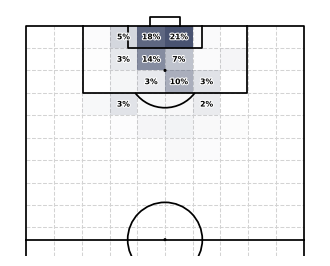

In [13]:
fig = plt.figure(figsize=(4,4), dpi=100)
ax = plt.subplot(111)

soc_pitch_divisions(ax, grids=True)

counter = 0
for X, Y in zip(example_df["bins_x"], example_df["bins_y"]):
	# this colours our bins
    ax.fill_between(
        x = [X.left, X.right],
        y1 = Y.left,
        y2 = Y.right,
        color = "#495371",
        alpha = example_df["xGOT_scaled"].iloc[counter],
        zorder = -1,
        lw = 0
    )
	
    # fancy annotations
    if example_df['xGOT_share'].iloc[counter] > .02:
        text_ = ax.annotate(
            xy = (X.right - (X.right - X.left)/2, Y.right - (Y.right - Y.left)/2),
            text = f"{example_df['xGOT_share'].iloc[counter]:.0%}",
            ha = "center",
            va = "center",
            color = "black",
            size = 5.5,
            weight = "bold",
            zorder = 3
        )

        text_.set_path_effects(
            [path_effects.Stroke(linewidth=1.5, foreground="white"), path_effects.Normal()]
        )

    counter += 1

Wrap into a function

In [14]:
def soc_xGOT_plot(ax, grids, teamId, data=df_teams):
    '''
    This plots our shot heat map based on the grids defined
    by the soc_pitch_divisions function.

    Args:
        ax (obj): a matplotlib Axes object.
        grids (bool): whether or not to plot the grids.
        teamId (int): the teamId of the side we wish to plot.
        data (pd.DataFrame): the data
    '''

    df = data.copy()
    df = data[data["teamId"] == teamId]
    total_xGOT = df["xGOT"].sum()

    df = (
        df
        .assign(xGOT_share = lambda x: x.xGOT/total_xGOT)
    )
    df = (
        df
        .assign(xGOT_scaled = lambda x: x.xGOT_share/x.xGOT_share.max())
    )

    soc_pitch_divisions(ax, grids = grids)

    counter = 0
    for X, Y in zip(df["bins_x"], df["bins_y"]):
        ax.fill_between(
            x = [X.left, X.right],
            y1 = Y.left,
            y2 = Y.right,
            color = "#495371",
            alpha = df["xGOT_scaled"].iloc[counter],
            zorder = -1,
            lw = 0
        )

        if df['xGOT_share'].iloc[counter] > .02:
            text_ = ax.annotate(
                xy = (X.right - (X.right - X.left)/2, Y.right - (Y.right - Y.left)/2),
                text = f"{df['xGOT_share'].iloc[counter]:.0%}",
                ha = "center",
                va = "center",
                color = "black",
                size = 6.5,
                weight = "bold",
                zorder = 3
            )

            text_.set_path_effects(
                [path_effects.Stroke(linewidth=1.5, foreground="white"), path_effects.Normal()]
            )

        counter += 1
    
    return ax

Test

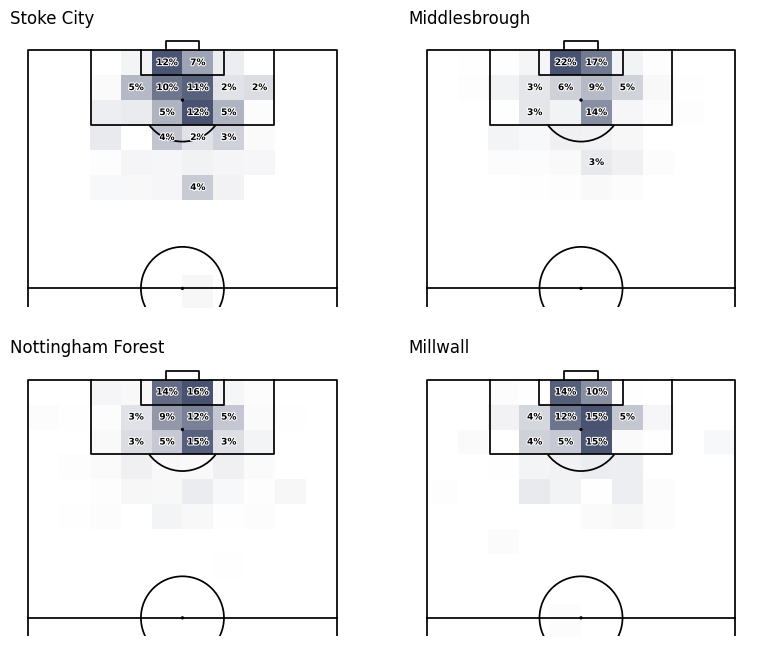

In [15]:
fig = plt.figure(figsize=(12, 8), dpi=100)

ax_1 = plt.subplot(221)
ax_2 = plt.subplot(222)
ax_3 = plt.subplot(223)
ax_4 = plt.subplot(224)


soc_xGOT_plot(ax_1, False, 10194, data = df_teams)
soc_xGOT_plot(ax_2, False, 8549, data = df_teams)
soc_xGOT_plot(ax_3, False, 10203, data = df_teams)
soc_xGOT_plot(ax_4, False, 10004, data = df_teams)

ax_1.set_title("Stoke City", loc = 'left')
ax_2.set_title("Middlesbrough", loc = 'left')
ax_3.set_title("Nottingham Forest", loc = 'left')
ax_4.set_title("Millwall", loc = 'left')

plt.subplots_adjust(wspace = -.25)

In [16]:
fig.savefig('../figures/07022022_efl-championship-shots.png', bbox_inches='tight')